# Analyzing the trained single-site/multi-site event classifiers

This notebook shows how to analyze the results of the trained models for classifying single-site and multi-site events.

Note that the models must exist in order for this notebook to work properly! Thus, if you haven't already, make sure to either run the `tutorial_classifier_training.ipynb` notebook or use the more advanced `train_classifier.py` script. If using the latter, also make sure to change the model paths below from their defaults, if needed.

## Configuration and imports

Start with the necessary imports.

For TensorFlow, there may be some CUDA-related warnings or information (especially if using the Binder image which does not have access to a GPU). Before importing `tensorflow`, set the environment variable `TF_CPP_MIN_LOG_LEVEL` to toggle which messages are printed (the code below forces TensorFlow to only print error messages, but feel free to change this).

See the table below for a list of all options. Note that the table is taken from [this StackOverflow answer](https://stackoverflow.com/a/38645250).

 Level | Level for Humans | Level Description
-------|------------------|------------------------------------ 
 0     | DEBUG            | [Default] Print all messages
 1     | INFO             | Filter out INFO messages
 2     | WARNING          | Filter out INFO & WARNING messages
 3     | ERROR            | Filter out all messages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from pathlib import Path

import numpy as np
import tensorflow as tf

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             log_loss, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc)

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
# For interactive plots (https://matplotlib.org/stable/users/explain/interactive.html).
# Uncomment the first line if using Jupyter Notebook
# Uncomment the second line if using Jupyterlab
#%matplotlib notebook
#%matplotlib widget

In [5]:
# Default matplotlib settings for the notebook to make plots look relatively OK.
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams['figure.figsize'] = (7, 4)
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['legend.labelspacing'] = 0.4
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.borderpad'] = 0.5

In [6]:
# For reproducibility.
np.random.seed(562853)
tf.random.set_seed(357358)

## Load the data

In this notebook, we load in the *test* data that was generated via the `generate_data.py` script. We covered in the previous tutorial notebook why you do not want to use the training data to evaluate the final model performance. We also do not want to use the validation set as we already used that to select the best model (specifically, we selected a model at the end of a certain epoch). Thus, here we use the last of the three data splits. The test set is the dataset for which we want to report our final results.

Do note that in practice, one would spend more time performing model selection than we did in the previous notebook. This would include trying out different architectures, testing different numbers of nodes in the hidden layers, trying different window sizes and number of filters (for the convolutional neural networks). Also note that methods other than the typical 80%-10%-10% (or whatever fractions you choose) train-validation-test split can be used. For example, [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is typically more robust and frequently used, although it is very computationally expensive.

We again print out some properties of the data, such as the maximum number of sites in the dataset and the fraction of events for each site. As a reminder, the data consist of simulated 1-dimensional pulses from a germanium detector. Each pulse is of length 512 samples and contains a random level of detector noise. Some of the pulses are single-site events, while others are multi-site events.

In [7]:
datadir = Path("../data/simulations")
subfolder = "test"

In [8]:
X_noisy = np.load(Path(datadir, subfolder, "X_noisy_library.npy"))
X_clean = np.load(Path(datadir, subfolder, "y_clean_library.npy"))
y_nsite = np.load(Path(datadir, subfolder, "y_nsite_library.npy"))

In [9]:
print(f"Shape of noisy pulse array: {X_noisy.shape}")
print(f"Shape of site number array: {y_nsite.shape}")

Shape of noisy pulse array: (3104, 512)
Shape of site number array: (3104, 1)


In [10]:
number, counts = np.unique(y_nsite, return_counts=True)
for n, c in zip(number, counts):
    print(f"Number of events with {n} site(s): {c}")

Number of events with 1 site(s): 1552
Number of events with 2 site(s): 388
Number of events with 3 site(s): 388
Number of events with 4 site(s): 388
Number of events with 5 site(s): 388


In [11]:
# Convert to binary value.
# Single-site events are class 0 and multi-site events are class 1.
y = (y_nsite > 1).astype(int)

In [12]:
y

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]])

## Plot example pulses

The following figures plot an example single-site and multi-site event, respectively. The noisy pulse, which is the input to the neural network for classifying multi-site events, is shown in blue. The corresponding clean underlying pulse is shown in orange. The derivative of the pulse is also shown to emphasize the peaks.

### Example single-site event

The code below gets a random event from all of the single-site events.

In [13]:
all_indexes_sse = np.arange(y.shape[0])[y[:, 0] == 0]
index_sse = np.random.choice(all_indexes_sse)

In [14]:
print(f"Index of single-site event: {index_sse}")
print(f"True number of sites in event: {y_nsite[index_sse, 0]}")
print(f"True class of event: {y[index_sse, 0]}")

Index of single-site event: 116
True number of sites in event: 1
True class of event: 0


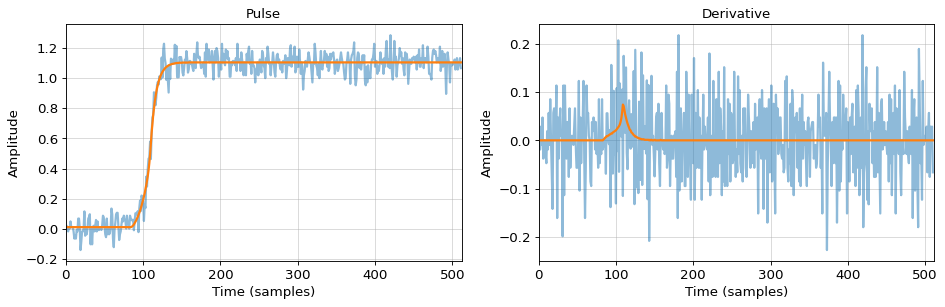

In [15]:
fig_sse, axes_sse = plt.subplots(ncols=2, figsize=(12, 4))

axes_sse[0].plot(X_noisy[index_sse], alpha=0.5)
axes_sse[0].plot(X_clean[index_sse])
axes_sse[0].set_xlim([0, X_noisy.shape[1]])

axes_sse[1].plot(np.diff(X_noisy[index_sse]), alpha=0.5)
axes_sse[1].plot(np.diff(X_clean[index_sse]))
axes_sse[1].set_xlim([0, X_noisy.shape[1]])

axes_sse[0].set_xlabel("Time (samples)")
axes_sse[1].set_xlabel("Time (samples)")

axes_sse[0].set_ylabel("Amplitude")
axes_sse[1].set_ylabel("Amplitude")

axes_sse[0].set_title("Pulse")
axes_sse[1].set_title("Derivative")

plt.tight_layout()

### Example multi-site event

The code below gets a random event from all of the multi-site events.

In [16]:
all_indexes_mse = np.arange(y.shape[0])[y[:, 0] == 1]
index_mse = np.random.choice(all_indexes_mse)

In [17]:
print(f"Index of multi-site event: {index_mse}")
print(f"True number of sites in event: {y_nsite[index_mse, 0]}")
print(f"True class of event: {y[index_mse, 0]}")

Index of multi-site event: 153
True number of sites in event: 5
True class of event: 1


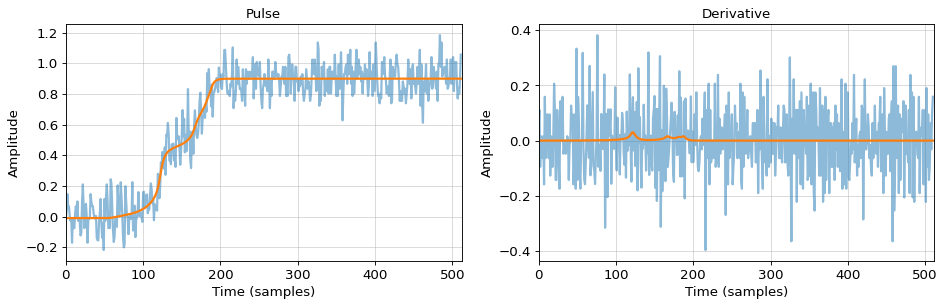

In [18]:
fig_mse, axes_mse = plt.subplots(ncols=2, figsize=(12, 4))

axes_mse[0].plot(X_noisy[index_mse], alpha=0.5)
axes_mse[0].plot(X_clean[index_mse])
axes_mse[0].set_xlim([0, X_noisy.shape[1]])

axes_mse[1].plot(np.diff(X_noisy[index_mse]), alpha=0.5)
axes_mse[1].plot(np.diff(X_clean[index_mse]))
axes_mse[1].set_xlim([0, X_noisy.shape[1]])

axes_mse[0].set_xlabel("Time (samples)")
axes_mse[1].set_xlabel("Time (samples)")

axes_mse[0].set_ylabel("Amplitude")
axes_mse[1].set_ylabel("Amplitude")

axes_mse[0].set_title("Pulse")
axes_mse[1].set_title("Derivative")

plt.tight_layout()

## Load in the models

The [`tf.keras.models.load_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) function is used to load in a trained model (as the name implies) saved on disk. If using the `SavedModel` format, the only argument needed is generally the model path. If using the older, but more lightweight, HDF5 file format, you will also need to pass in any custom objects (specifically, Python functions or classes used in defining the model) as those are not included in the saved HDF5 file.

In [19]:
model_dense = tf.keras.models.load_model("../models/classifiers/dense_nn")

In [20]:
model_cnn = tf.keras.models.load_model("../models/classifiers/cnn")

## Make predictions

Use the [`tf.keras.Model.predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict) method on a numpy array to obtain the predictions. This method takes a number of arguments, such as the batch size. It is also compatible with a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object instead of an array-like object.

Note that the outputs are floating point numbers between zero and one, and so we must set a threshold to determine the class (where any value greater than the threshold is considered multi-site). As a start, it makes sense to choose 0.5, especially if the output is interpreted as a probability that the given event is mult-site.

In [21]:
y_pred_vals_dense = model_dense.predict(X_noisy, batch_size=512, verbose=1)

7/7 [==============================] - 0s 3ms/step


In [22]:
y_pred_vals_cnn = model_cnn.predict(X_noisy, batch_size=512, verbose=1)

7/7 [==============================] - 0s 8ms/step


In [23]:
print(y_pred_vals_dense)

[[0.7190653 ]
 [0.89446545]
 [0.01496539]
 ...
 [0.94066596]
 [0.06848872]
 [0.06971592]]


In [24]:
# Convert predictions to a binary value.
y_pred_dense = (y_pred_vals_dense > 0.5).astype(int)
y_pred_cnn = (y_pred_vals_cnn > 0.5).astype(int)

In [25]:
print(y_pred_dense)

[[1]
 [1]
 [0]
 ...
 [1]
 [0]
 [0]]


In [26]:
print(np.squeeze(y_pred_dense[0:20]))

[1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0]


In [27]:
print(np.squeeze(y_pred_cnn[0:20, 0]))

[1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0]


## Evaluate the models using the TensorFlow model methods

The models can now be evaluated. The [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class has an [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) method that will compute the values for metrics that the model was compiled with and return them. Here, we call the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) method on a set of input and target pairs. Again, this method supports calls using a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object instead of array-like objects. The `return_dict` argument ensures the returned object is a dictionary with the keys as the metric names. In this case, the loss function is exactly the same as the categorical cross-entropy. However, in general, the loss will contain any additional constraints on the network such as regularization penalties.

In [28]:
results_dict_dense = model_dense.evaluate(x=X_noisy, y=y, batch_size=512, verbose=1, return_dict=True)

7/7 [==============================] - 0s 2ms/step - loss: 0.2766 - binary_accuracy: 0.8876


In [29]:
results_dict_cnn = model_cnn.evaluate(x=X_noisy, y=y, batch_size=512, verbose=1, return_dict=True)

7/7 [==============================] - 0s 8ms/step - loss: 0.1719 - binary_accuracy: 0.9391


### Compare metrics

In [30]:
# For formatting the output of the print statements.
max_len = max(len(k) for k in results_dict_dense.keys())

In [31]:
print("Metrics for dense model:")
for metric, metric_val in results_dict_dense.items():
    print(f"{metric:<{max_len}} | {metric_val:.4f}")

Metrics for dense model:
loss            | 0.2766
binary_accuracy | 0.8876


In [32]:
print("Metrics for CNN model:")
for metric, metric_val in results_dict_cnn.items():
    print(f"{metric:<{max_len}} | {metric_val:.4f}")

Metrics for CNN model:
loss            | 0.1719
binary_accuracy | 0.9391


## Evaluate the models using scikit-learn methods

[scikit-learn](https://scikit-learn.org/stable/) is a library for machine learning with many useful tools. It has numerous algotithms for machine learning, but also contains evaluation tools that are compatible with numpy arrays. Since we have the predictions from TensorFlow, functions from scikit-learn can also be used for evaluation. Here, we use scikit-learn metrics such as the [`accuracy_score`](https://scikit-learn.org/1.1/modules/generated/sklearn.metrics.accuracy_score.html) and [`log_loss`](https://scikit-learn.org/1.1/modules/generated/sklearn.metrics.log_loss.html) (which is just another name for the categorical cross-entropy). These are a part of the [`sklearn.metrics`](https://scikit-learn.org/1.1/modules/classes.html#module-sklearn.metrics) module, which contains numerous classification and regression metrics. As can be seen below, both functions produce the same values as the equivalent TensorFlow metrics. However, since we have now saved the predicted values, it is easier to use these functions for more detailed analysis.

The [`confusion_matrix`](https://scikit-learn.org/1.1/modules/generated/sklearn.metrics.confusion_matrix.html) function and [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) class are yet another set of tools we use. The reason for looking at the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is because the overall accuracy of a model can be misleading, especially if the classes are imbalanced. The confusion matrix can help us to better understand where the neural network is doing well and where it is going wrong. See the linked documentation for a description of the confusion matrix and the indexing convention used by scikit-learn. The [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) class does the same thing as the [`confusion_matrix`](https://scikit-learn.org/1.1/modules/generated/sklearn.metrics.confusion_matrix.html) function, but also plots it in a visual way with labels and colours.

We will also use [`recall_score`](https://scikit-learn.org/1.1/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score) and [`precision_score`](https://scikit-learn.org/1.1/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) from the [`sklearn.metrics`](https://scikit-learn.org/1.1/modules/classes.html#module-sklearn.metrics) module for similar reasons.

### Fully-connected (i.e., dense) neural network

Calculate the overall accuracy, cross-entropy loss, precision, and recall.

In [33]:
acc_dense = accuracy_score(y, y_pred_dense) * 100
bce_dense = log_loss(y, y_pred_vals_dense)

In [34]:
print(f"Overall accuracy: {acc_dense:.2f}%")
print(f"Cross-entropy:    {bce_dense:.4f}")

Overall accuracy: 88.76%
Cross-entropy:    0.2766


In [35]:
prec_dense = precision_score(y, y_pred_dense) * 100
recl_dense = recall_score(y, y_pred_dense) * 100

In [36]:
print(f"Precision (tp / (tp + fp)):  {prec_dense:.2f}%")
print(f"Recall    (tp / (tp + fn)):  {recl_dense:.2f}%")

Precision (tp / (tp + fp)):  93.87%
Recall    (tp / (tp + fn)):  82.93%


In [37]:
# Create the confusion matrix.
cm_dense = confusion_matrix(y, y_pred_dense)

In [38]:
print(cm_dense)
print("")
print(cm_dense / cm_dense.sum(axis=1, keepdims=True))

[[1468   84]
 [ 265 1287]]

[[0.94587629 0.05412371]
 [0.17074742 0.82925258]]


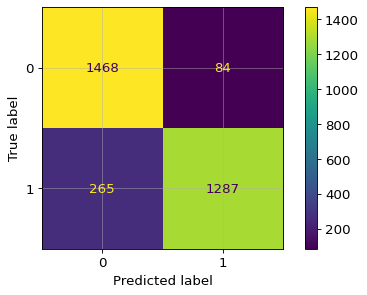

In [39]:
# Plot the confusion matrix in a much more pleasant format.
_ = ConfusionMatrixDisplay(confusion_matrix=cm_dense).plot()

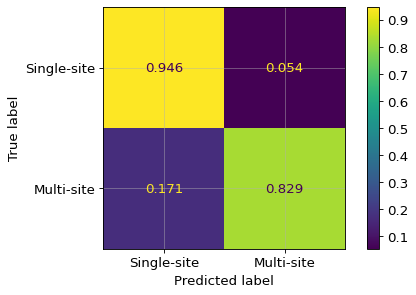

In [40]:
# Use the static ConfusionMatrixDisplay.from_predictions method
# to use the targets and predictions and to specify more options.
_ = ConfusionMatrixDisplay.from_predictions(y, y_pred_dense,
                                            values_format=".3f",
                                            normalize="true",
                                            display_labels=["Single-site", "Multi-site"])

### Convolutional neural network

Calculate the overall accuracy, cross-entropy loss, precision, and recall.

In [41]:
acc_cnn = accuracy_score(y, y_pred_cnn) * 100
bce_cnn = log_loss(y, y_pred_vals_cnn)

In [42]:
print(f"Overall accuracy: {acc_cnn:.2f}%")
print(f"Cross-entropy:    {bce_cnn:.4f}")

Overall accuracy: 93.91%
Cross-entropy:    0.1719


In [43]:
prec_cnn = precision_score(y, y_pred_cnn) * 100
recl_cnn = recall_score(y, y_pred_cnn) * 100

In [44]:
print(f"Precision (tp / (tp + fp)):  {prec_cnn:.2f}%")
print(f"Recall    (tp / (tp + fn)):  {recl_cnn:.2f}%")

Precision (tp / (tp + fp)):  98.16%
Recall    (tp / (tp + fn)):  89.50%


In [45]:
# Create the confusion matrix.
cm_cnn = confusion_matrix(y, y_pred_cnn)

In [46]:
print(cm_cnn)
print("")
print(cm_cnn / cm_cnn.sum(axis=1, keepdims=True))

[[1526   26]
 [ 163 1389]]

[[0.98324742 0.01675258]
 [0.10502577 0.89497423]]


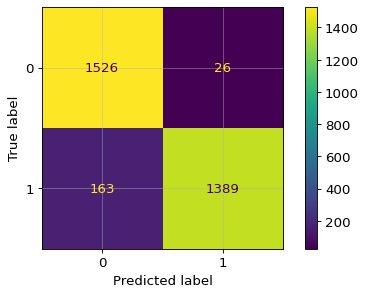

In [47]:
# Plot the confusion matrix in a much more pleasant format.
_ = ConfusionMatrixDisplay(confusion_matrix=cm_cnn).plot()

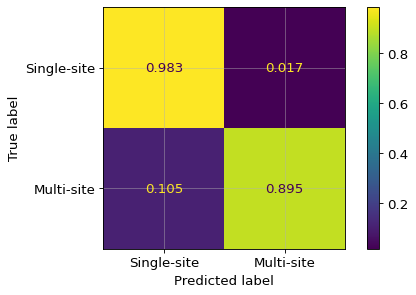

In [48]:
# Use the static ConfusionMatrixDisplay.from_predictions method
# to use the targets and predictions and to specify more options.
_ = ConfusionMatrixDisplay.from_predictions(y, y_pred_cnn,
                                            values_format=".3f",
                                            normalize="true",
                                            display_labels=["Single-site", "Multi-site"])

## Comparison metrics

Overall metrics are a useful starting point, and breaking the results down by target is even better. From these results, it is clear that the network is better at classifying single-site events than multi-site events. But why is that the case? Where is the network making mistakes? To understand this, we need to further break down the metrics by other quantities.

### Metrics as a function of number of sites

Let's start by plotting the classification accuracy as a function of the number of sites. Since we are selecting only events of a certain number of sites, this is effectively plotting the recall for $n \ge 2$. For single-site events ($n=1$), this represents the recall when the single-site event class is the positive label.

In [49]:
acc_dense_list_nsites = [accuracy_score(y[y_nsite==n], y_pred_dense[y_nsite==n]) * 100
                         for n in number]

In [50]:
acc_cnn_list_nsites = [accuracy_score(y[y_nsite==n], y_pred_cnn[y_nsite==n]) * 100
                       for n in number]

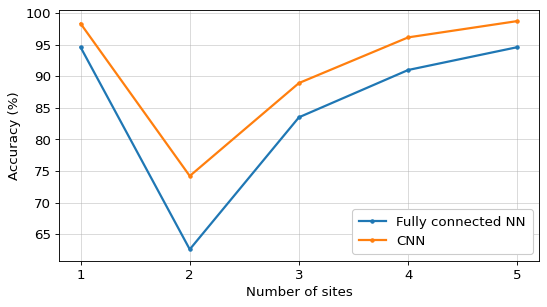

In [51]:
plt.figure()
plt.plot(number, acc_dense_list_nsites, '.-', label="Fully connected NN")
plt.plot(number, acc_cnn_list_nsites, '.-', label="CNN")
plt.xticks(range(1, 6, 1))
plt.xlabel("Number of sites")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()

By calculating the accuracy based on the number of sites, it is clear that the network has difficulty classifying two-site events specifically. Intuitively, this makes sense: an event can have two interactions occur very close in time, making the event appear as single-site due to the overlap. This is less likely to occur as the number of interactions within the event window increase.

### Metrics as a function of standard deviation of the baseline (i.e., noise level $\sigma$)

Another aspect of the pulses which might affect the classification performance is the noise level. With more noise, it intuitively makes sense that the network might have trouble distinguishing certain multi-site events as the noise could dominate any visible signs. Let's plot the classification accuracy as a function of the noise level, which we will bin in increments of 0.02 to ensure a reasonable amount of data in each bin.

In [52]:
sigma_range_w = 0.02
sigma_range = np.arange(0, 0.2 + sigma_range_w, sigma_range_w)
print(sigma_range)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]


In [53]:
sigma = X_noisy[:, :50].std(axis=1, keepdims=True)

In [54]:
acc_dense_list_sigma = []
for s_low, s_high in zip(sigma_range[:-1], sigma_range[1:]):
    mask = np.logical_and(sigma >= s_low, sigma < s_high)
    acc_dense_list_sigma.append(accuracy_score(y[mask], y_pred_dense[mask]))

In [55]:
acc_cnn_list_sigma = []
for s_low, s_high in zip(sigma_range[:-1], sigma_range[1:]):
    mask = np.logical_and(sigma >= s_low, sigma < s_high)
    acc_cnn_list_sigma.append(accuracy_score(y[mask], y_pred_cnn[mask]))

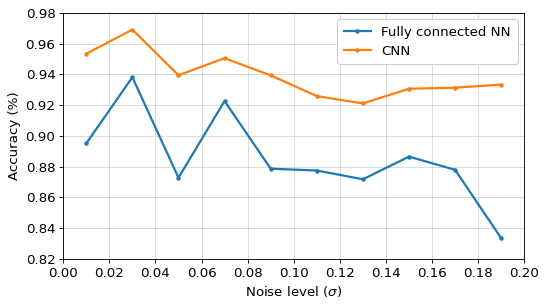

In [56]:
plt.figure()
plt.plot(sigma_range[:-1] + sigma_range_w/2, acc_dense_list_sigma, '.-', label="Fully connected NN")
plt.plot(sigma_range[:-1] + sigma_range_w/2, acc_cnn_list_sigma, '.-', label="CNN")
plt.xticks(sigma_range)
plt.xlabel("Noise level ($\sigma$)")
plt.ylabel("Accuracy (%)")
plt.ylim([0.82, 0.98])
plt.legend()
plt.tight_layout()

So the accuracy does decrease as a function of the noise level, but not as much as one might expect (especially accounting for the apparent uncertainty in the points). More data may be needed to get a better representation. Let's try making the same plot with the recall.

In [57]:
recl_dense_list_sigma = []
for s_low, s_high in zip(sigma_range[:-1], sigma_range[1:]):
    mask = np.logical_and(sigma >= s_low, sigma < s_high)
    recl_dense_list_sigma.append(recall_score(y[mask], y_pred_dense[mask]))

In [58]:
recl_cnn_list_sigma = []
for s_low, s_high in zip(sigma_range[:-1], sigma_range[1:]):
    mask = np.logical_and(sigma >= s_low, sigma < s_high)
    recl_cnn_list_sigma.append(recall_score(y[mask], y_pred_cnn[mask]))

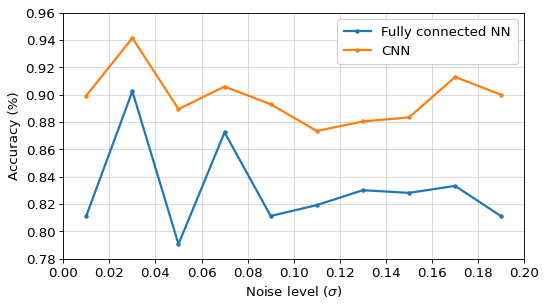

In [59]:
plt.figure()
plt.plot(sigma_range[:-1] + sigma_range_w/2, recl_dense_list_sigma, '.-', label="Fully connected NN")
plt.plot(sigma_range[:-1] + sigma_range_w/2, recl_cnn_list_sigma, '.-', label="CNN")
plt.xticks(sigma_range)
plt.xlabel("Noise level ($\sigma$)")
plt.ylabel("Accuracy (%)")
plt.ylim([0.78, 0.96])
plt.legend()
plt.tight_layout()

Again, there is not much of a trend, indicating that the performance does not depend too much on the noise level. However, each bin does not have a lot of data points, and there seems to be a lot of fluctuation between the different noise bins.

### Raw classification scores

Until now, we have looked at the classes predicted by the neural networks, but not the scores themselves. Since this is a binary classification problem and we apply the sigmoid function to the output of the network, the score can be interpreted as a probability.

**A word of warning**: There is a lot more nuance to simply interpreting the output of the network as a probability or uncertaintly. In practice, neural networks tend to be too condident in their predictions. Despite this, it can sometimes work reasonably enough, and for this notebook we may still intrepret these values as roughly how confident the neural network is in the prediction. Just remember for your own research that this is not a trivial problem.

Let's histogram the scores for each class, giving them different colours to separate them.

In [60]:
mask_pos = y[:, 0] == 1
mask_neg = y[:, 0] == 0

In [61]:
score_bins = np.linspace(0, 1, 51)

#### Fully-connected (i.e., dense) neural network

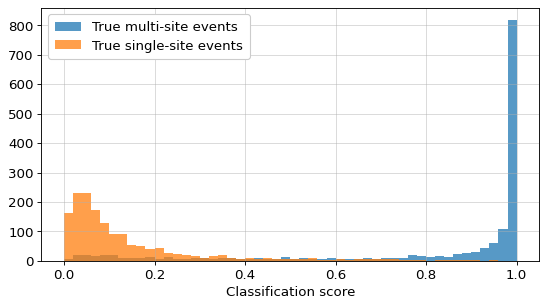

In [62]:
plt.hist(y_pred_vals_dense[mask_pos], bins=score_bins, alpha=0.75,
         label="True multi-site events")
plt.hist(y_pred_vals_dense[mask_neg], bins=score_bins, alpha=0.75,
         label="True single-site events")

plt.xlabel("Classification score")

# Try plotting this figure with a logarithmic y-axis.
#plt.yscale("log")

plt.legend()

plt.tight_layout()

#### Convolutional neural network

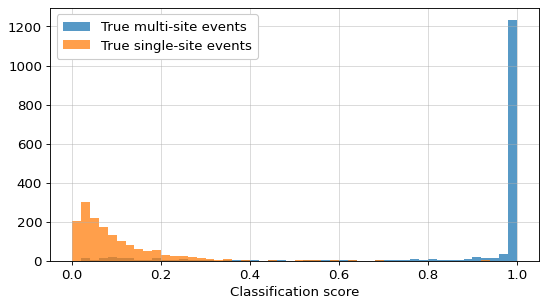

In [63]:
plt.hist(y_pred_vals_cnn[mask_pos], bins=score_bins, alpha=0.75,
         label="True multi-site events")
plt.hist(y_pred_vals_cnn[mask_neg], bins=score_bins, alpha=0.75,
         label="True single-site events")

plt.xlabel("Classification score")

# Try plotting this figure with a logarithmic y-axis.
#plt.yscale("log")

plt.legend()

plt.tight_layout()

### Receiver Operating Characteristic curve

We can see that the network tends to be very confident in predicting multi-site events, assigning almost all of the true multi-site events a very high score. The distribution of scores for single-site events, in contrast, is more spread out.

In all previous analysis, we have considered a threshold of 0.5 to split the classification between single-site and multi-site events. However, is this the optimal threshold? As well, for certain problems, we may care much more about classifiying a certain event type correctly than the other option. Classifying a certain event type *incorrectly* may also have serious implications. This will ultimately depend on the problem at hand.

To see the effect of changing the score threshold for classification, we can use the [Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC) curve. With the ROC cruve, the true positive rate is plotted as a function of the false positive rate. Since one wants to maximize the true positive rate while minimizing the false positive rate, the optimal ROC curve should look more like a step function starting at zero. Furthermore, the [area under the curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Probabilistic_interpretation), or AUC, should be maximal (and ideally one, although that is simply unrealistic).

Fortunately, the the [`sklearn.metrics`](https://scikit-learn.org/1.1/modules/classes.html#module-sklearn.metrics) module has a [`roc_curve`](https://scikit-learn.org/1.1/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) function that will vary the threshold of discrimination and return the false and true positive rates. Let's plot the ROC curves for both trained models.

In [64]:
fpr_dense, tpr_dense, thres_dense = roc_curve(np.squeeze(y, axis=-1), np.squeeze(y_pred_vals_dense, axis=-1))
auc_dense = auc(fpr_dense, tpr_dense)

In [65]:
fpr_cnn, tpr_cnn, thres_cnn = roc_curve(np.squeeze(y, axis=-1), np.squeeze(y_pred_vals_cnn, axis=-1))
auc_cnn = auc(fpr_cnn, tpr_cnn)

In [66]:
index_half_dense = np.argmin(np.abs(thres_dense - 0.5))

In [67]:
index_half_cnn = np.argmin(np.abs(thres_cnn - 0.5))

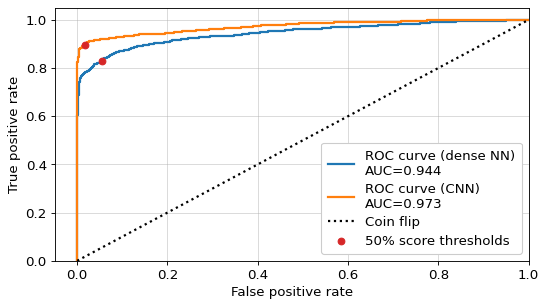

In [68]:
plt.plot(fpr_dense, tpr_dense,
         label=f"ROC curve (dense NN)\nAUC={auc_dense:.3f}")
plt.plot(fpr_cnn, tpr_cnn,
         label=f"ROC curve (CNN)\nAUC={auc_cnn:.3f}")
plt.plot([0, 1], [0, 1], color='k', linestyle=":", label="Coin flip")
plt.scatter(fpr_dense[index_half_dense], tpr_dense[index_half_dense], color='tab:red', zorder=101,
            label="50% score thresholds")
plt.scatter(fpr_cnn[index_half_cnn], tpr_cnn[index_half_cnn], color='tab:red', zorder=101)

plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.legend()
plt.tight_layout()

It is clear that the convolutional neural network is superior. For reference, the ROC curve for a random guess (i.e., a coin flip) is plotted on the figure. The points on the ROC curve where the threshold for discrimination is 50% (i.e., what we have typically been assuming) are also included.

## Visualize the incorrectly classified pulses

Now that we understand a bit better where the neural network is going wrong, let's take a look at an example. We will create a mask of all pulses that are classified incorrectly, and then draw a random index from that.

In [69]:
mask_incorrect = np.squeeze(y != y_pred_cnn, axis=-1)

In [70]:
index_wrong_class = np.random.choice(np.arange(y.shape[0])[mask_incorrect])

In [71]:
print(f"Index of event with incorrect classification: {index_wrong_class}")
print(f"True number of sites in event: {y_nsite[index_wrong_class, 0]}")
print(f"True class of event: {y[index_wrong_class, 0]}")
print(f"Predicted class from dense network: {y_pred_dense[index_wrong_class, 0]}")
print(f"Predicted score from dense network: {y_pred_vals_dense[index_wrong_class, 0]:.2f}")
print(f"Predicted class from CNN: {y_pred_cnn[index_wrong_class, 0]}")
print(f"Predicted score from CNN: {y_pred_vals_cnn[index_wrong_class, 0]:.2f}")

Index of event with incorrect classification: 1874
True number of sites in event: 2
True class of event: 1
Predicted class from dense network: 1
Predicted score from dense network: 0.67
Predicted class from CNN: 0
Predicted score from CNN: 0.46


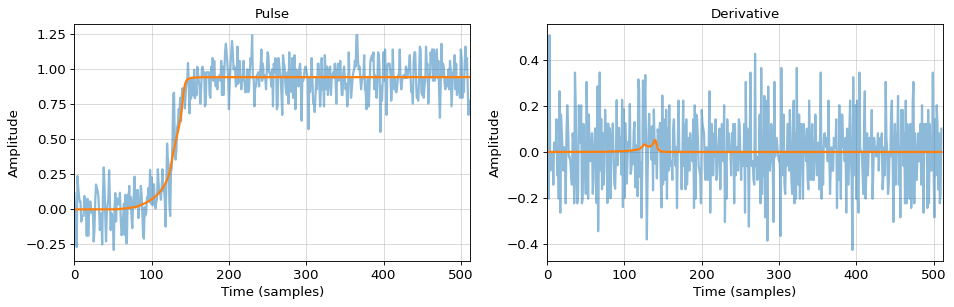

In [72]:
fig_wrong_class, axes_wrong_class = plt.subplots(ncols=2, figsize=(12, 4))

axes_wrong_class[0].plot(X_noisy[index_wrong_class], alpha=0.5)
axes_wrong_class[0].plot(X_clean[index_wrong_class])
axes_wrong_class[0].set_xlim([0, X_noisy.shape[1]])

axes_wrong_class[1].plot(np.diff(X_noisy[index_wrong_class]), alpha=0.5)
axes_wrong_class[1].plot(np.diff(X_clean[index_wrong_class]))
axes_wrong_class[1].set_xlim([0, X_noisy.shape[1]])

axes_wrong_class[0].set_xlabel("Time (samples)")
axes_wrong_class[1].set_xlabel("Time (samples)")

axes_wrong_class[0].set_ylabel("Amplitude")
axes_wrong_class[1].set_ylabel("Amplitude")

axes_wrong_class[0].set_title("Pulse")
axes_wrong_class[1].set_title("Derivative")

plt.tight_layout()

So, this pulse is a multi-site event classified as a single-site event. The two sites are very close in time and difficult to distinguish with the high noise level. It is not too surprising that the network is having difficulty classifying this particular event. Interestingly, this is an example of where the dense network was correct and the CNN was wrong!

It is also interesting to note that the prediction value from the neural network is fairly close to 0.5, indicating that it is not particularly confident in its prediction. That being said, it is not too difficult to find an event where the neural network is confidentially incorrect. Try running the above cells a few times and find an example.

## Conclusion and questions

This is the end of the tutorial. Now that we have gone through and trained several models along with evaluating their results, it's time to think of ways we can improve. Alhough the classifier does quite well given a small amount of data, it really struggles with two-site events. It also has a harder time classifying high-noise events. Both of these problems are obvious, but can we fix them (or at least improve what we have now)?

Here are some questions to think about and explore. Remember to consider both the neural network architecture as well as the data generation process. You will need to modify both this and the previous notebook to better understand these questions.

- I've talked a bit about overfitting. How would you force the network to overfit? Try to get the network to do as well on the training set and poor on the validation set as possible.
- Try plotting another metric as a function of the number of sites and the noise level.
- Take a look at pulses where the two networks disagree. Is there a pattern?
- The performance on two-site events is the worst, which makes sense as they are typically the most difficult to distinguish from single-site events. How can we improve the accuracy on two-site events?
- We used [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) for optimization, but in practice SDG is rarely used without some extension. There are various improvements such as momentum, and also new optimizers such as Adam. Try to improve the performance of the model solely by changing the optimizer in some way.
- How many events in the training set do we need before improvements in the metrics become negligible?
- How many epochs of training do we need before improvements in the metrics become negligible?
- How can we change the structure/architecture of the network to improve the results? Does adding more and more layers help?
- Try to create a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object from the numpy arrays we have been using and train the network with it.
- How can we modify the code to predict a different quantity? For example, what about predicting the rise time? Remember to consider every step of the process from generating the labels to structuring the training for regression.